<a href="https://colab.research.google.com/github/Splav12341/H-M_kaggle_competiton/blob/main/graphical_appearance_no.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import numpy as np
import time
from collections import defaultdict
from tqdm import tqdm

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Wed Apr 27 22:20:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.129      Driver Version: 410.129      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:59:00.0 Off |                    0 |
| N/A   40C    P0    60W / 312W |  14264MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
DATA_PATH = r"./../H&M/images"

NUM_WORKERS = 8
SIZE_H = SIZE_W = 256

EPOCH_NUM = 30
BATCH_SIZE = 250

# Images mean and std channelwise
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

In [ ]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      # converting to tensors
    transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])

In [ ]:
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset

In [ ]:
import pandas as pd
df = pd.read_csv('./../H&M/articles.csv')
df = df.astype({'article_id': 'str'})

# Make Dataset

In [ ]:
class DatasetImageFolder(torch.utils.data.Dataset):
    def __init__(self, DATA_PATH: str, df, transform):
        super(DatasetImageFolder, self).__init__()
        self.root = DATA_PATH
        self.transform = transform
        self.class_names = []
        self.images_filepaths = []
 
        for directory in tqdm(sorted(os.listdir(os.path.join(DATA_PATH)))):
            for fname in os.listdir(os.path.join(DATA_PATH + '/' + directory)):
                for row in df.values:
                    if fname[1:-4] == row[0]:
                        self.images_filepaths.append(row[0])
                        self.class_names.append(row[1])
                        df = df.drop(df[df.article_id == row[0]].index)
                        break
                        
        self.target_dict = dict()
        for idx, label in enumerate(np.unique(self.class_names)):
            self.target_dict[label] = idx

    def __len__(self):
        return len(self.images_filepaths)
 
    def __getitem__(self, idx):
        
        image_filepath = ('./../H&M/images/' + '0' + str(test_dataset.images_filepaths[idx])[:2] + '/0' + 
                                str(test_dataset.images_filepaths[idx]) +'.jpg')
        image = Image.open(image_filepath)
     
        label = torch.tensor(self.target_dict[self.class_names[idx]])
        try:
            image = self.transform(image)
        except RuntimeError:
            print('aaaaa:', image_filepath)
            
            image = torch.zeros((3, 256, 256))
            label = torch.tensor(0)
        return image, label, self.images_filepaths[idx]

In [ ]:
column = 'graphical_appearance_no'
test_dataset = DatasetImageFolder(DATA_PATH, df[['article_id', column]], transformer)

100%|██████████| 86/86 [21:19<00:00, 14.87s/it]


## pseudo balance classes

In [ ]:
unique, counts = np.unique(test_dataset.class_names, return_counts=True)

In [ ]:
counts

array([   51, 17128,  1337,    15,  2176,  1820,   680,  1163,  3210,
         954,  5918,   337,  1127,   510,  3094,   806, 49450,  4980,
         583,    81,   376,  1511,   826,  4835,   318,   153,  1501,
          66,    86,     8])

In [ ]:
unique

array([     -1, 1010001, 1010002, 1010003, 1010004, 1010005, 1010006,
       1010007, 1010008, 1010009, 1010010, 1010011, 1010012, 1010013,
       1010014, 1010015, 1010016, 1010017, 1010018, 1010019, 1010020,
       1010021, 1010022, 1010023, 1010024, 1010025, 1010026, 1010027,
       1010028, 1010029])

In [ ]:
df[column].value_counts()

 1010016    49747
 1010001    17165
 1010010     5938
 1010017     4990
 1010023     4842
 1010008     3215
 1010014     3098
 1010004     2178
 1010005     1830
 1010021     1513
 1010026     1502
 1010002     1341
 1010007     1165
 1010012     1132
 1010009      958
 1010022      830
 1010015      806
 1010006      681
 1010018      586
 1010013      515
 1010020      376
 1010011      346
 1010024      322
 1010025      153
 1010019       86
 1010028       86
 1010027       66
-1             52
 1010003       15
 1010029        8
Name: graphical_appearance_no, dtype: int64

## choose balance_number

In [ ]:
d = dict()
balance_number = 5000.

for idx, value in enumerate(counts):
    weight = int(balance_number/value)
    d[unique[idx]] = weight
print(d)

{-1: 98, 1010001: 0, 1010002: 3, 1010003: 333, 1010004: 2, 1010005: 2, 1010006: 7, 1010007: 4, 1010008: 1, 1010009: 5, 1010010: 0, 1010011: 14, 1010012: 4, 1010013: 9, 1010014: 1, 1010015: 6, 1010016: 0, 1010017: 1, 1010018: 8, 1010019: 61, 1010020: 13, 1010021: 3, 1010022: 6, 1010023: 1, 1010024: 15, 1010025: 32, 1010026: 3, 1010027: 75, 1010028: 58, 1010029: 625}


## Balanced dataset 

In [ ]:
class BalancedDatasetImageFolder(torch.utils.data.Dataset):
    def __init__(self, DATA_PATH: str, transform, class_names, images_filepaths, target_dict):
        super().__init__()
        self.root = DATA_PATH
        self.transform = transform
        self.class_names = class_names.copy()
        self.images_filepaths = images_filepaths.copy()
                        
        self.target_dict = target_dict.copy()

    def __len__(self):
        return len(self.images_filepaths)
 
    def __getitem__(self, idx):
        image_filepath = ('./../H&M/images/' + '0' + str(self.images_filepaths[idx])[:2] + '/0' + 
                                str(self.images_filepaths[idx]) +'.jpg')
        image = Image.open(image_filepath)
        label = torch.tensor(self.target_dict[self.class_names[idx]])
        try:
            image = self.transform(image)
        except RuntimeError:
            print('aaaaa:', image_filepath)
            
            image = torch.zeros((3, 256, 256))
            label = torch.tensor(0)
        return image, label, self.images_filepaths[idx]

In [ ]:
balanced_dataset = BalancedDatasetImageFolder(DATA_PATH, transformer, test_dataset.class_names, test_dataset.images_filepaths, test_dataset.target_dict)

In [ ]:
class_names = []
images_filepaths = []
for name, path in tqdm(zip(balanced_dataset.class_names, balanced_dataset.images_filepaths)):
    
    tmp_names = []
    tmp_paths = []
    if d[name]>0:
        tmp_names.append(name)
        tmp_names = tmp_names*d[name]
        tmp_paths.append(path)
        tmp_paths = tmp_paths*d[name]

        class_names.extend(tmp_names)
        images_filepaths.extend(tmp_paths)
        
balanced_dataset.class_names.extend(class_names)
balanced_dataset.images_filepaths.extend(images_filepaths)    

105100it [00:00, 891309.85it/s]


## checking

In [ ]:
unique, counts = np.unique(balanced_dataset.class_names, return_counts=True)

In [ ]:
counts

array([ 5049, 17128,  5348,  5010,  6528,  5460,  5440,  5815,  6420,
        5724,  5918,  5055,  5635,  5100,  6188,  5642, 49450,  9960,
        5247,  5022,  5264,  6044,  5782,  9670,  5088,  5049,  6004,
        5016,  5074,  5008])

In [ ]:
unique, counts = np.unique(test_dataset.class_names, return_counts=True)

In [ ]:
counts

array([   51, 17128,  1337,    15,  2176,  1820,   680,  1163,  3210,
         954,  5918,   337,  1127,   510,  3094,   806, 49450,  4980,
         583,    81,   376,  1511,   826,  4835,   318,   153,  1501,
          66,    86,     8])

# DataLoader

In [ ]:
img, label, images_filepaths = balanced_dataset[0]
print(img.shape)
print(label)

torch.Size([3, 256, 256])
tensor(16)


In [ ]:
NUM_WORKERS=4
train_loader = DataLoader(balanced_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

emb_train_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [ ]:
# train_iter = iter(train_loader)
# it = next(train_iter)
# print(len(it))
# print(it[0].shape)
# print(it[1])

## plot samples

In [ ]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch, images_filepaths = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    class_names = batch_gen.dataset.class_names
    for i in range(grid_size[0] * grid_size[1]):
        
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)
        
        # display batch samples with labels
#         sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        sample_title = 'Label = %s' % class_names[label_batch[i]]
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)

In [ ]:
# plot_from_batch_generator(train_loader)

## define num_classes

In [ ]:
NUM_CLASSES = len(np.unique(train_loader.dataset.class_names))

# Download model

In [ ]:
# !pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
# Load pre-trained model
# model_resnet18 = torchvision.models.resnet152(pretrained=True)
from collections import OrderedDict
model = EfficientNet.from_pretrained('efficientnet-b4')

# Disable gradient updates for all the layers except  the final layer
# YOUR CODE HERE
for p in model.parameters():
    p.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_feat = model._fc.in_features

# hid_size = 200
emb_size = 20
model._fc = nn.Linear(num_feat, emb_size)

model = nn.Sequential(OrderedDict([
          ('efficientnet', model),
          ('leaky_relu1', nn.LeakyReLU(0.3)),
          ('lin', nn.Linear(emb_size, NUM_CLASSES)),
          ('leaky_relu2', nn.LeakyReLU(0.3))
]))

# Use available device for calculations
model = model.to(device)

Loaded pretrained weights for efficientnet-b4


In [ ]:
!mkdir ./models
CHECKPOINT_PATH = "./models/save3"

mkdir: cannot create directory ‘./models’: File exists


In [ ]:
# torch.save(model.state_dict(),CHECKPOINT_PATH)
# model.load_state_dict(torch.load(CHECKPOINT_PATH))
# model = model.to(device)

In [ ]:
# model(it[0].to(device)).shape

## tensorboard

In [ ]:
# !rm -r ./runs/log

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('runs/log')

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir=./runs --bind_all --port=6007# bind_all for remoted python
# # or use http://tpls-sgmta00001.sigma.sbrf.ru:6006/

## training

In [ ]:
from IPython.display import clear_output
import time
from sklearn.metrics import accuracy_score

def fit(model, epochs, lr):
    torch.cuda.empty_cache()
    
    opt = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
    train_losses = []
    accuracy = []
    start = time.time()
    i=0
    flag = False
    for epoch in range(epochs):
        model.train(True)
        for img, label, images_filepaths in tqdm(train_loader):
            clear_output(True)
            img = img.to(device)
            label = label.to(device)
            opt.zero_grad()
            preds = model(img).to(device)
            ce_loss = nn.CrossEntropyLoss()
            loss = ce_loss(preds, label)
            loss.backward()
            opt.step()
            tmp_loss = loss.item()
            train_losses.append(tmp_loss)
            
            end = time.time() - start
            
            acc = accuracy_score(label.cpu(), np.argmax(preds.cpu().detach().numpy(), axis=1))
            accuracy.append(acc)
            
            # if i%10==1:
            plt.plot(np.arange(0, len(train_losses)), train_losses, label=f'spent_time={end}, ep={epoch}')
            plt.legend()
            plt.show()

            plt.plot(np.arange(0, len(accuracy)), accuracy, label='accuracy')
            plt.legend()
            plt.show()
            
            if (np.mean(accuracy[-5:])>0.75):
                flag = True
            
            i+=1
        
        torch.save(model.state_dict(),CHECKPOINT_PATH)
        if flag == True:
            break
    model.train(False)
    return model

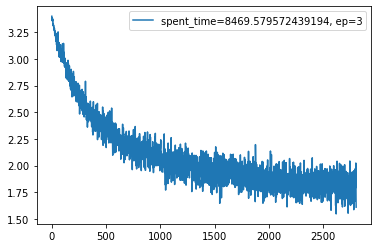

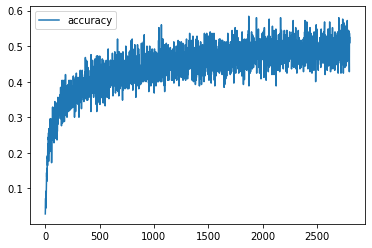

  6%|▌         | 52/917 [01:56<32:10,  2.23s/it]


KeyboardInterrupt: 

In [ ]:
EPOCH_NUM=100
model = fit(model, EPOCH_NUM , lr=0.0003)

In [ ]:
torch.save(model.state_dict(),CHECKPOINT_PATH)

In [ ]:
model.load_state_dict(torch.load(CHECKPOINT_PATH))
model = model.to(device)

# Make embeddings

In [ ]:
df = np.zeros((len(test_dataset.images_filepaths), emb_size+1))
i=0
for img, label, images_filepaths in tqdm(emb_train_loader):
    img = img.to(device)
    preds = model.efficientnet(img).cpu().detach().numpy()
    
    for k in range(img.shape[0]):
        df[i*BATCH_SIZE + k, 0] = int(images_filepaths[k])
        for m in range(emb_size):
            df[i*BATCH_SIZE + k, m+1] = preds[k,m:m+1][0]
    i+=1
    
df = pd.DataFrame(df)
print(df.shape)
df.head()

 59%|█████▉    | 249/421 [08:11<07:46,  2.71s/it]

aaaaa: ./../H&M/images/061/0616100001.jpg


 90%|████████▉ | 378/421 [12:22<01:28,  2.07s/it]

In [ ]:
df

In [ ]:
df.to_csv('./checkpoint3.csv')